<a href="https://colab.research.google.com/github/saurabfaruque/pythonintro/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Packages

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

# for regressions:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.linear_model as sklm

# for KNN:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

#for model evaluation and pre-processing tools:
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score, \
                            accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

#for modeling with decision trees:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, \
    RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier

#for model tuning:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

#for plotting confusion matrix:
!pip install scikit-plot
import scikitplot as skplt

# For explaining predictions and visualizing explanations
!pip install shap
import shap


#for plotting decision trees
!pip install pydotplus
!pip install graphviz
import pydotplus as pplus
import graphviz
from IPython.display import Image
from six import StringIO

In [2]:
#dmba stuff
!pip install dmba
from dmba import regressionSummary, exhaustive_search
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import classificationSummary, gainsChart, liftChart, plotDecisionTree

Colab environment detected.


In [3]:
#These are utility tools of the DMBA book. Install the "dmba" package first
!pip install dmba
from dmba import regressionSummary, exhaustive_search
from dmba import adjusted_r2_score, AIC_score, BIC_score

In [4]:
# visualization and tuning the aesthetics
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use('seaborn-whitegrid')

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [5]:
#This function helps with drawing decision trees using the pydotplus and graphviz libraries
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names

    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)

In [6]:
# Mount the Google Drive to work with Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Upload Data & Clean

In [7]:
df1 = pd.read_csv('/content/drive/My Drive/intropy/Session_10/Italy_Wave1.csv')
df2 = pd.read_csv('/content/drive/My Drive/intropy/Session_10/Italy_Wave3.csv', usecols=['idstd', 'COVb0'])
df2.rename(columns={'COVb0': 'openstatus'}, inplace=True)
df_italy = pd.merge(df1, df2, on='idstd', how='left')


df3 = pd.read_csv('/content/drive/My Drive/intropy/Session_10/Greece_Wave1.csv')
df4 = pd.read_csv('/content/drive/My Drive/intropy/Session_10/Greece_Wave3.csv', usecols=['idstd', 'COVb0'])
df4.rename(columns={'COVb0': 'openstatus'}, inplace=True)
df_greece = pd.merge(df1, df2, on='idstd', how='left')

# Combine Italy and Greece data
df = pd.concat([df_italy, df_greece], ignore_index=True)

In [8]:
#replace missing with NaN
df.replace(".", np.nan, inplace=True)
values_to_replace = ["Don't know (spontaneous)", "Does not apply (spontaneous)", "Don't know", "Does not apply"]
df.replace(values_to_replace, np.nan, inplace=True)
df = df.replace([-99, -9, -77, -7], np.nan)
df = df.replace('-77', np.nan)
df = df.replace('-7', np.nan)

In [9]:
# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().mean()

# Identify columns where the percentage of missing values is greater than 50%
columns_to_drop = missing_percentage[missing_percentage > 0.5].index

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop)

# List of columns to be dropped (not relevant variables or not included in data dictionary or survey documentation)
columns_to_drop2 = ["id", "a1", "COVb0", "mode", "a1a", 'a22', 'a23', 'a24', 'a25', 'a26', "COVa20y", "COVa20m", "COVa20d", "COVa20m_1", "COVg1", "COVg3", "COVg4", 'statuscode','eligibilitycode', 'strata', 'wmedian_ES', 'wmedian_COVID', 'wweak_COVID', 'idstd']

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop2)


In [10]:
# Replacing labels with numbers, ordinal
df.replace({'Increase': 1, 'Remain the same': 2, 'Decrease':3}, inplace=True)

# Convert continuous variables to float
continuous_vars = ['COVb3a', 'COVb3b', 'COVb3c', 'COVc5', 'COVc6', 'COVd1', 'COVd2', 'COVd8']
df[continuous_vars] = df[continuous_vars].astype(float)

In [11]:
import pandas as pd

# Create dummy variable for open status (if open =1, otherwise=0)
df['Open'] = df['openstatus'].apply(lambda x: 1 if x == "Open" else 0)

# Drop the original 'openstatus' column
df = df.drop('openstatus', axis=1)


In [12]:
#rename predicted variable to 'target'
df.rename(columns={'Open': 'target'}, inplace=True)

In [13]:
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import random

#IMPUTE MISSING WITH EITHER MEDIAN OR PROPORTION

# List of ordinal and continuous variables
ordinal_vars = ['COVb2a', 'COVb4', 'COVc2a', 'COVc2c', 'COVc2b', 'COVd3a', 'COVd3b', 'COVe1a', 'COVe1b', 'COVe1c']
continuous_vars = ['COVb3a', 'COVb3b', 'COVb3c', 'COVc5', 'COVc6', 'COVd1', 'COVd2', 'COVd8']

# Variables to exclude from imputation
exclude_imputation = ['target']

# Create imputer for median
median_imputer = SimpleImputer(strategy='median')

def proportional_imputation(column):
    # Get the distribution of non-NaN values
    value_counts = column.value_counts(normalize=True)

    # Generate random values according to the distribution
    return column.apply(lambda x: np.random.choice(value_counts.index, p=value_counts.values) if pd.isnull(x) else x)

# Iterate over each column in the DataFrame
for column in df.columns:
    # Skip imputation for excluded variables
    if column in exclude_imputation:
        continue

    if column in ordinal_vars or column in continuous_vars:
        # Impute using median for ordinal and continuous variables
        df[[column]] = median_imputer.fit_transform(df[[column]])
    else:
        # Impute using proportional value for categorical variables
        df[column] = proportional_imputation(df[column])



# Feature Selection Using Supervised Learning


The goal is to identify the most important variables at Wave 1 that are predictive of Wave 3 Open status.

### Setup Target & Training sets

In [14]:
# Target variable dummy
targetdummy = pd.get_dummies(df['target'])
df['target2'] = targetdummy[1]
yvar = df['target2'].astype('float64')

# Dummies for all other categorical variables
# Exclude the original and dummy target variables
Xvar = pd.get_dummies(df.drop(['target', 'target2'], axis=1))

In [15]:
# Split the data into training and test portions
X2_train, X2_test, Y2_train, Y2_test = train_test_split(Xvar, yvar, test_size=0.40, random_state=7)
print(X2_train.shape, Y2_train.shape)
print(X2_test.shape, Y2_test.shape)

(912, 42) (912,)
(608, 42) (608,)


### Decision Tree Classifier Model


We run this model first to get an idea of how accurate a simpler model is.

In [16]:
# Decision Tree Classifier Model
DT_target = DecisionTreeClassifier(random_state=23)

In [17]:
# set the gridsearch parameters for decision tree
dtc_param_grid={'max_depth':[5, 7, 10], 'max_leaf_nodes':np.arange(2,10), 'max_features': [10, 15, 20]}

In [18]:
# define the gridsearch for decision tree classification:
dtc_grid_search = GridSearchCV(DT_target, dtc_param_grid, cv=5, scoring='accuracy')

In [19]:
# Fit the model on training data
dtc_grid_search.fit(X2_train, Y2_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=23),
             param_grid={'max_depth': [5, 7, 10], 'max_features': [10, 15, 20],
                         'max_leaf_nodes': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='accuracy')

In [20]:
dtc_grid_search.cv_results_['mean_test_score']

array([0.58118057, 0.63051702, 0.67770372, 0.7149943 , 0.71167958,
       0.70618507, 0.70507416, 0.70288837, 0.58118057, 0.63272083,
       0.65685462, 0.70401729, 0.71387137, 0.72266859, 0.71606918,
       0.71497028, 0.5702456 , 0.62397766, 0.66126224, 0.70844292,
       0.71169759, 0.7150003 , 0.71169759, 0.70950579, 0.58118057,
       0.63051702, 0.67770372, 0.7149943 , 0.71167958, 0.70728397,
       0.70508617, 0.72485438, 0.58118057, 0.63272083, 0.65685462,
       0.70401729, 0.71387137, 0.72046478, 0.72815108, 0.72376148,
       0.5702456 , 0.62397766, 0.66126224, 0.70844292, 0.71169759,
       0.7150003 , 0.71279649, 0.7106047 , 0.58118057, 0.63051702,
       0.67770372, 0.7149943 , 0.71167958, 0.70728397, 0.70508617,
       0.72485438, 0.58118057, 0.63272083, 0.65685462, 0.70401729,
       0.71387137, 0.72046478, 0.72815108, 0.72485438, 0.5702456 ,
       0.62397766, 0.66126224, 0.70844292, 0.71169759, 0.7150003 ,
       0.71279649, 0.7106047 ])

In [21]:
dtc_grid_search.best_params_

{'max_depth': 7, 'max_features': 15, 'max_leaf_nodes': 8}

In [22]:
dtc_grid_search.best_estimator_

DecisionTreeClassifier(max_depth=7, max_features=15, max_leaf_nodes=8,
                       random_state=23)

Visualize the Decision Tree:

In [23]:
#get the names of the independent variables for using them in the tree plot
df_features=df.drop(['target','target2'], axis=1).columns

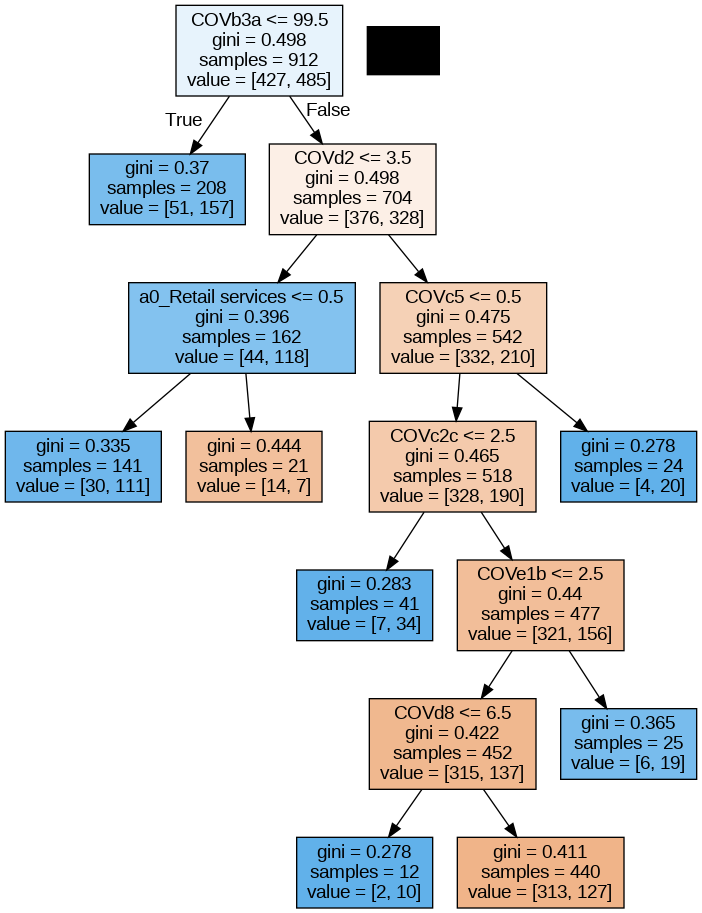

In [24]:
# Get the correct feature names from the DataFrame used for training
df_features = Xvar.columns

# Now, you can use df_features for the print_tree function
DTcgraph = print_tree(dtc_grid_search.best_estimator_, features=df_features)
Image(DTcgraph.create_png())


In [25]:
# Predictions of the best decision tree classifier
DT_prediction_ctc=dtc_grid_search.best_estimator_.predict(X2_test)

In [26]:
# Evaluate how good the decision tree classification is:
cm_DTC = confusion_matrix(Y2_test, DT_prediction_ctc)
print("Confusion Matrix:\n", cm_DTC)
print("\n")
print("Classification Report:\n",classification_report(Y2_test, DT_prediction_ctc))

Confusion Matrix:
 [[213  64]
 [ 96 235]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.77      0.73       277
         1.0       0.79      0.71      0.75       331

    accuracy                           0.74       608
   macro avg       0.74      0.74      0.74       608
weighted avg       0.74      0.74      0.74       608



The accuracy of this model isn't perfect, but 75% accuracy is pretty good given that it is predicting something as significant as whether the business is Open.

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

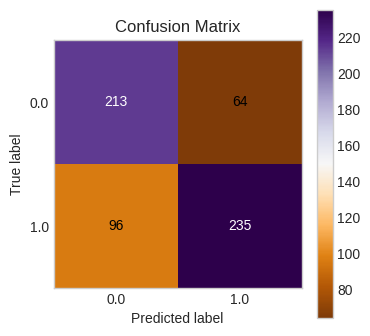

In [27]:
skplt.metrics.plot_confusion_matrix(Y2_test, DT_prediction_ctc, figsize=(4,4), cmap="PuOr")

In [28]:
1-df.target2.mean()

0.4631578947368421

### Random Forest Classifier

Because this data has outliers and is not parametric, RF Classifier is the perferred method. It is more robust to outliers and noise. It also gives us insight into feature importance.

In [29]:
# RandomForest Classifier Model
DT_target_rfc = RandomForestClassifier(random_state=23)

In [30]:
# set the gridsearch parameters for the RandomForest Classifier
dtfc_param_grid={'n_estimators': [10, 15, 20], 'max_depth':[5, 10, 15], \
                 'max_leaf_nodes':np.arange(2,10), 'min_samples_split':[5, 10, 15]}

In [31]:
# define the gridsearch for decision tree classification:
dtrfc_grid_search = GridSearchCV(DT_target_rfc, dtfc_param_grid, cv=5, scoring='accuracy')

In [32]:
# Fit the model on training data
dtrfc_grid_search.fit(X2_train, Y2_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=23),
             param_grid={'max_depth': [5, 10, 15],
                         'max_leaf_nodes': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [10, 15, 20]},
             scoring='accuracy')

In [33]:
dtrfc_grid_search.cv_results_['mean_test_score']

array([0.6919474 , 0.70622711, 0.69854681, 0.6919474 , 0.70622711,
       0.69854681, 0.6919474 , 0.70622711, 0.69854681, 0.70186753,
       0.707314  , 0.7040293 , 0.70076863, 0.7051162 , 0.7029244 ,
       0.70076863, 0.7051162 , 0.7029244 , 0.71171561, 0.72375548,
       0.71827899, 0.7095178 , 0.72155768, 0.71827899, 0.7095178 ,
       0.72155768, 0.71827899, 0.72047679, 0.72486639, 0.72596529,
       0.72157569, 0.72596529, 0.72596529, 0.72596529, 0.72595929,
       0.72596529, 0.7259713 , 0.72706419, 0.72926199, 0.72376148,
       0.7270702 , 0.72816309, 0.72486039, 0.7237795 , 0.72816309,
       0.7259713 , 0.73035489, 0.7303669 , 0.72924998, 0.72926199,
       0.7303669 , 0.72924998, 0.7281691 , 0.7314658 , 0.73364559,
       0.73035489, 0.73145379, 0.73034889, 0.72926199, 0.7314598 ,
       0.72705218, 0.73035489, 0.7314598 , 0.73145379, 0.72816309,
       0.72925599, 0.73145379, 0.73145379, 0.7336576 , 0.73035489,
       0.73035489, 0.7303609 , 0.6919474 , 0.70622711, 0.69854

In [34]:
dtrfc_grid_search.best_params_

{'max_depth': 10,
 'max_leaf_nodes': 9,
 'min_samples_split': 15,
 'n_estimators': 10}

In [35]:
dtrfc_grid_search.best_estimator_

RandomForestClassifier(max_depth=10, max_leaf_nodes=9, min_samples_split=15,
                       n_estimators=10, random_state=23)

In [36]:
# Get the predictions of the best Random Forest classifier
DTrfc_prediction_ctc=dtrfc_grid_search.best_estimator_.predict(X2_test)

In [37]:
# Evaluate how good the Random Forest classification is:
cm_DTC = confusion_matrix(Y2_test, DTrfc_prediction_ctc)
print("Confusion Matrix:\n", cm_DTC)
print("\n")
print("Classification Report:\n",classification_report(Y2_test, DTrfc_prediction_ctc, zero_division=1))

Confusion Matrix:
 [[202  75]
 [ 74 257]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.73      0.73       277
         1.0       0.77      0.78      0.78       331

    accuracy                           0.75       608
   macro avg       0.75      0.75      0.75       608
weighted avg       0.75      0.75      0.75       608



The RF model performs similarly, only slightly better than the DT model

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

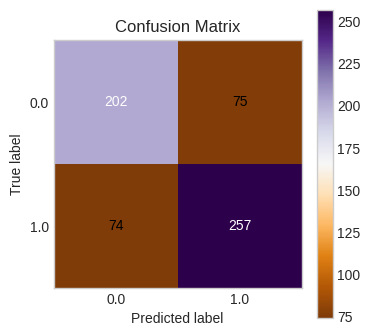

In [38]:
skplt.metrics.plot_confusion_matrix(Y2_test, DTrfc_prediction_ctc, figsize=(4,4), cmap="PuOr")

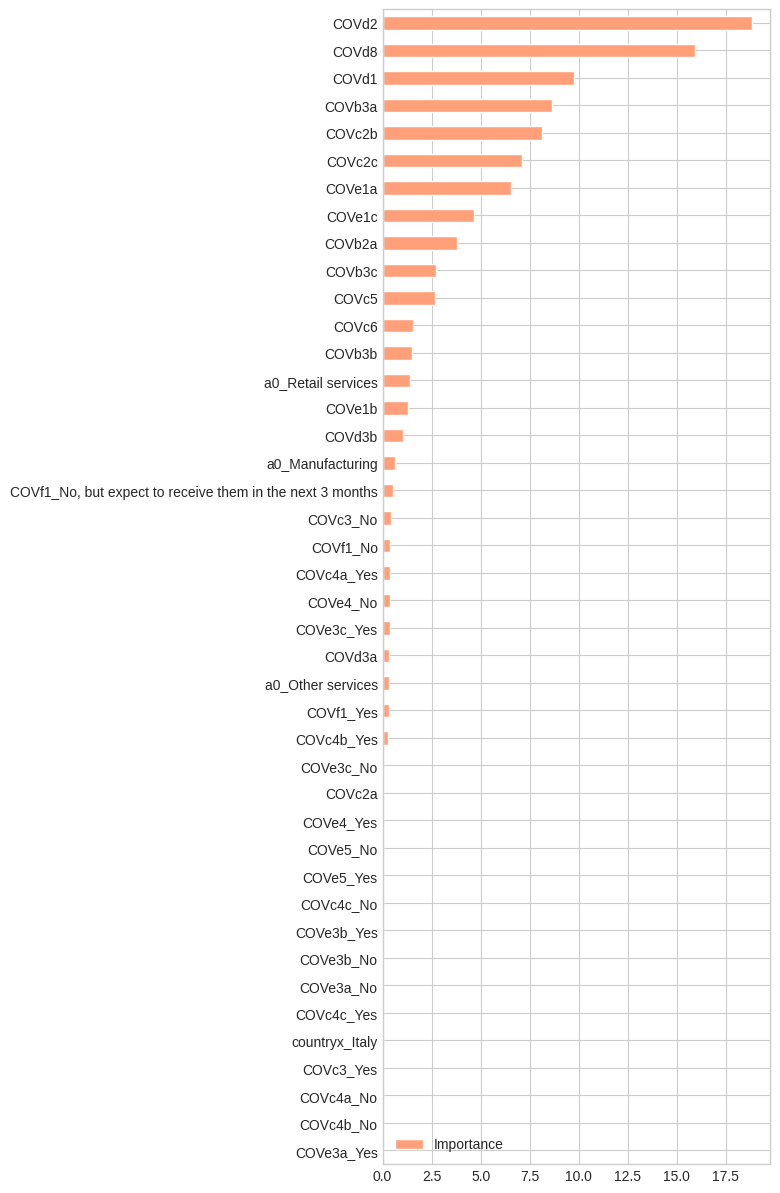

In [39]:
%matplotlib inline
Importance = pd.DataFrame({'Importance':dtrfc_grid_search.best_estimator_.feature_importances_*100}, \
                          index=df_features)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='lightsalmon', )
plt.gcf().set_size_inches(5, 15)

In [40]:
explainer2 = shap.TreeExplainer(dtrfc_grid_search.best_estimator_)
shap_values2=explainer2.shap_values(X2_test)
expected_value2 = explainer2.expected_value

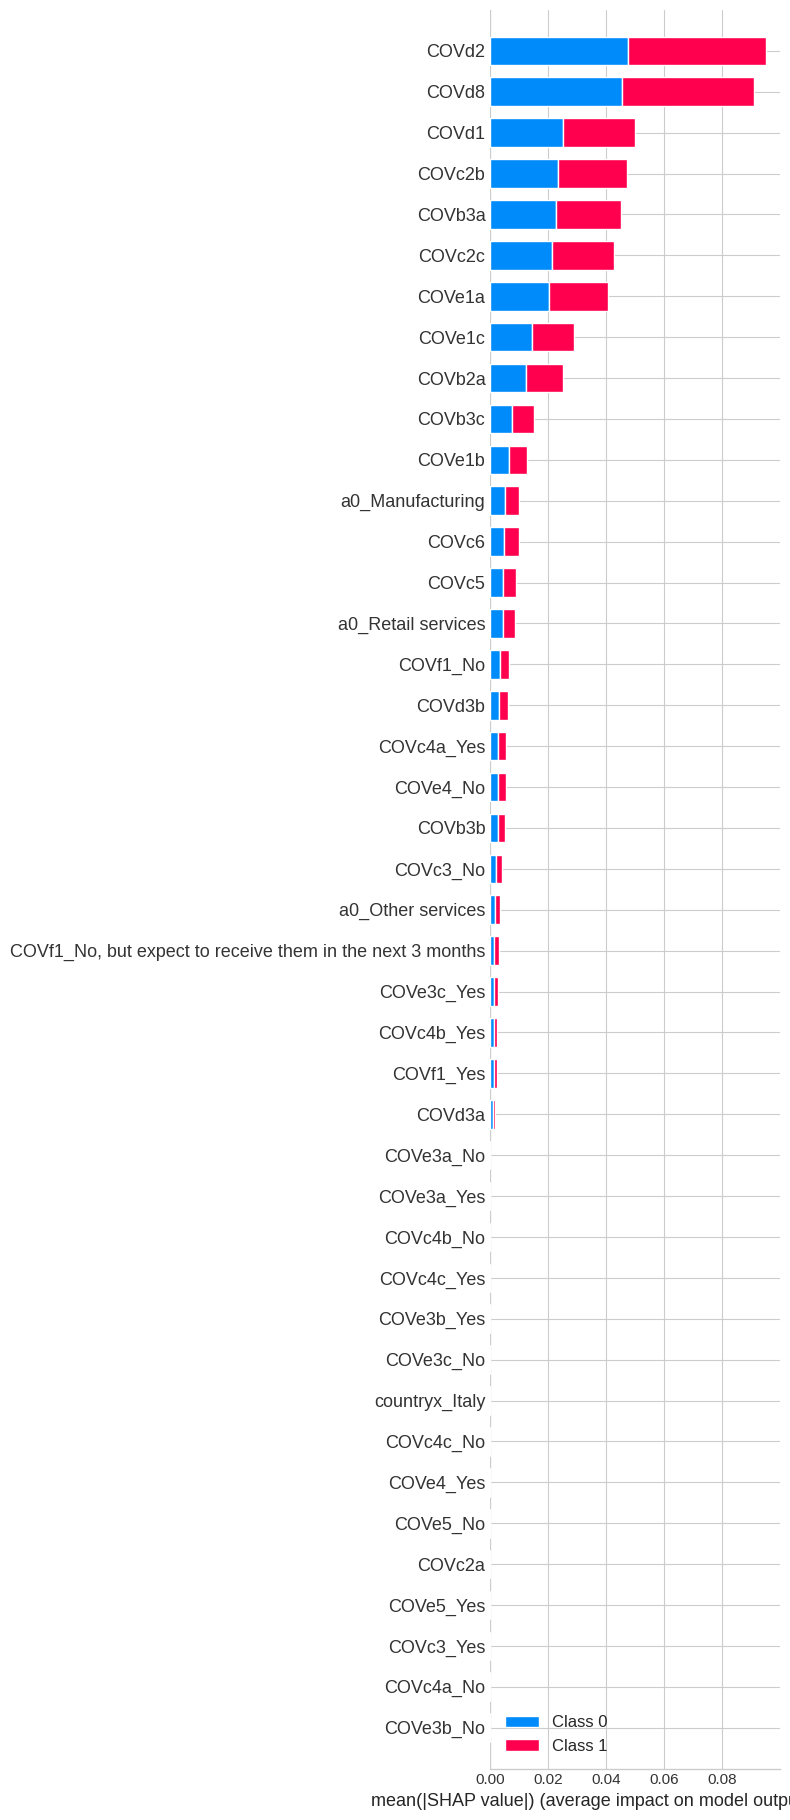

In [41]:
shap.summary_plot(shap_values2, X2_test, plot_type="bar", feature_names = df_features, max_display=100)

Variables consistently at the top of most important list after running this section several times:

COVd8 COVd1 COVd2

## Variables Identified


LABOR


COVd8

Since the outbreak of COVID-19, how many workers have been furloughed?


COVd1

At the end of the last completed month, that is in [insert last completed month], how many permanent, full-time employees did this establishment employ? Please include all employees and managers


COVd2

At the end of the last completed month, that is the end of [insert last completed month], in this establishment how many permanent, full-time workers were female?



In [42]:
import pandas as pd

correlation = df['COVd1'].corr(df['COVd2'])
print("Pearson correlation:", correlation)


Pearson correlation: 0.6534640051555237


## Selected Variables:



### LABOR


COVd8 (selected because consistently at the top of importance list)

Since the outbreak of COVID-19, how many workers have been furloughed?


COVd1 (selected because consistently at the top of importance list)

At the end of the last completed month, that is in [insert last completed month], how many permanent, full-time employees did this establishment employ? Please include all employees and managers

COVd2 was not included because it is correlated with COVd1


# Descriptives

# Upload Data & Clean

In [107]:
df1 = pd.read_csv('/content/drive/My Drive/intropy/Session_10/Italy_Wave1.csv')
df2 = pd.read_csv('/content/drive/My Drive/intropy/Session_10/Italy_Wave3.csv', usecols=['idstd', 'COVb0'])
df2.rename(columns={'COVb0': 'openstatus'}, inplace=True)
df_italy = pd.merge(df1, df2, on='idstd', how='left')


df3 = pd.read_csv('/content/drive/My Drive/intropy/Session_10/Greece_Wave1.csv')
df4 = pd.read_csv('/content/drive/My Drive/intropy/Session_10/Greece_Wave3.csv', usecols=['idstd', 'COVb0'])
df4.rename(columns={'COVb0': 'openstatus'}, inplace=True)
df_greece = pd.merge(df1, df2, on='idstd', how='left')

# Combine Italy and Greece data
df = pd.concat([df_italy, df_greece], ignore_index=True)

In [108]:
#replace missing with NaN
df.replace(".", np.nan, inplace=True)
values_to_replace = ["Don't know (spontaneous)", "Does not apply (spontaneous)", "Don't know", "Does not apply"]
df.replace(values_to_replace, np.nan, inplace=True)
df = df.replace([-99, -9, -77, -7], np.nan)
df = df.replace('-77', np.nan)
df = df.replace('-7', np.nan)

In [109]:
# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().mean()

# Identify columns where the percentage of missing values is greater than 50%
columns_to_drop = missing_percentage[missing_percentage > 0.5].index

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop)

# List of columns to be dropped (not relevant variables or not included in data dictionary or survey documentation)
columns_to_drop2 = ["id", "a1", "COVb0", "mode", "a1a", 'a22', 'a23', 'a24', 'a25', 'a26', "COVa20y", "COVa20m", "COVa20d", "COVa20m_1", "COVg1", "COVg3", "COVg4", 'statuscode','eligibilitycode', 'strata', 'wmedian_ES', 'wmedian_COVID', 'wweak_COVID', 'idstd']

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop2)


In [110]:
# Replacing labels with numbers, ordinal
df.replace({'Increase': 1, 'Remain the same': 2, 'Decrease':3}, inplace=True)

# Convert continuous variables to float
continuous_vars = ['COVb3a', 'COVb3b', 'COVb3c', 'COVc5', 'COVc6', 'COVd1', 'COVd2', 'COVd8']
df[continuous_vars] = df[continuous_vars].astype(float)

In [111]:
import pandas as pd

# Create dummy variable for open status (if open =1, otherwise=0)
df['Open'] = df['openstatus'].apply(lambda x: 1 if x == "Open" else 0)

# Drop the original 'openstatus' column
df = df.drop('openstatus', axis=1)


In [112]:
#rename predicted variable to 'target'
df.rename(columns={'Open': 'target'}, inplace=True)

# Descriptives & Visualization

In [113]:
import pandas as pd

# Descriptive statistics for the full sample
full_sample_descriptives = df[['COVd1', 'COVd8']].describe()

# Descriptive statistics for subgroups
target_0_descriptives = df[df['target'] == 0][['COVd1', 'COVd8']].describe()
target_1_descriptives = df[df['target'] == 1][['COVd1', 'COVd8']].describe()

# Printing the results
print("Full Sample Descriptive Statistics:\n", full_sample_descriptives)
print("\nTarget = 0 Descriptive Statistics:\n", target_0_descriptives)
print("\nTarget = 1 Descriptive Statistics:\n", target_1_descriptives)


Full Sample Descriptive Statistics:
             COVd1       COVd8
count  830.000000  802.000000
mean    71.315663   37.832918
std    120.444429   93.259438
min      1.000000    0.000000
25%      7.250000    0.000000
50%     20.000000    7.000000
75%     80.000000   27.000000
max    780.000000  750.000000

Target = 0 Descriptive Statistics:
             COVd1       COVd8
count  204.000000  196.000000
mean    60.205882   39.112245
std    113.430201   94.638300
min      1.000000    0.000000
25%      5.000000    1.000000
50%     10.500000    5.000000
75%     50.000000   27.000000
max    602.000000  602.000000

Target = 1 Descriptive Statistics:
             COVd1       COVd8
count  626.000000  606.000000
mean    74.936102   37.419142
std    122.513160   92.884284
min      1.000000    0.000000
25%      9.000000    0.000000
50%     25.000000    7.000000
75%     90.000000   28.500000
max    780.000000  750.000000


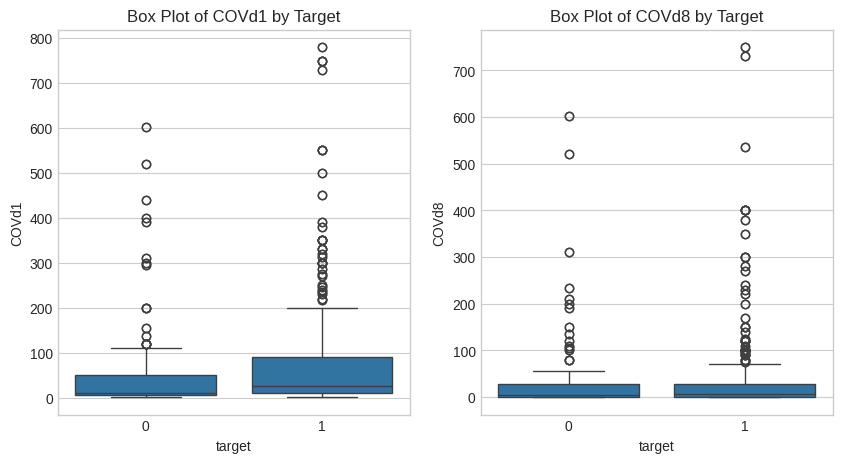

In [116]:
# Calculate percentiles for COVd1
lower_limit_d1 = df['COVd1'].quantile(0.01)
upper_limit_d1 = df['COVd1'].quantile(0.99)

# Calculate percentiles for COVd8
lower_limit_d8 = df['COVd8'].quantile(0.01)
upper_limit_d8 = df['COVd8'].quantile(0.99)

# Box Plot with adjusted y-axis limits
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='target', y='COVd1', data=df)
plt.title('Box Plot of COVd1 by Target')

plt.subplot(1, 2, 2)
sns.boxplot(x='target', y='COVd8', data=df)
plt.title('Box Plot of COVd8 by Target')
plt.show()


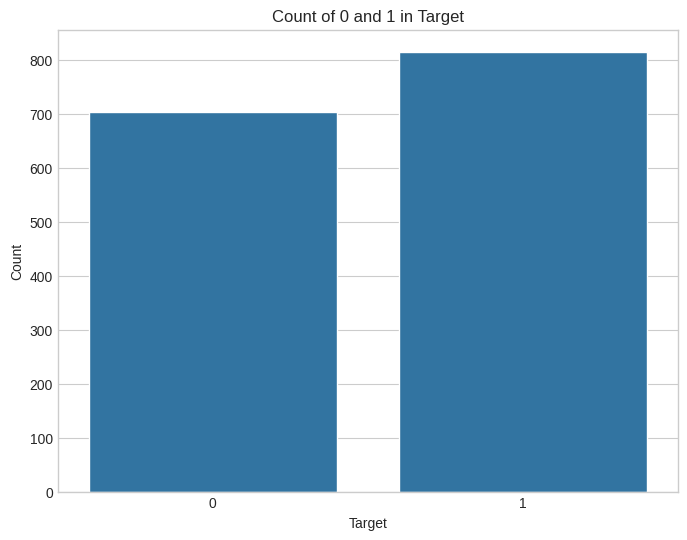

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each class (0 and 1)
class_counts = df['target'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Count of 0 and 1 in Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['0', '1'])  # Ensures that x-ticks are specifically 0 and 1
plt.show()


# Models containing selected features

## Setup

In [43]:
import pandas as pd
import numpy as np

# for regressions:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.linear_model as sklm

# for KNN:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

#for model evaluation and pre-processing tools:
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score, \
                            accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

#for modeling with decision trees:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, \
    RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier

#for model tuning:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

#for plotting confusion matrix:
!pip install scikit-plot
import scikitplot as skplt

# For explaining predictions and visualizing explanations
!pip install shap
import shap

#for plotting decision trees
import pydotplus as pplus
import graphviz
from IPython.display import Image
from six import StringIO

In [44]:
#These are utility tools of the DMBA book. Install the "dmba" package first
!pip install dmba
from dmba import regressionSummary, exhaustive_search
from dmba import adjusted_r2_score, AIC_score, BIC_score

In [45]:
# visualization and tuning the aesthetics
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use('seaborn-whitegrid')

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
import scikitplot as skplt

## KNN Model

### Upload Data & Clean

In [47]:
df1 = pd.read_csv('/content/drive/My Drive/intropy/Session_10/Italy_Wave1.csv')
df2 = pd.read_csv('/content/drive/My Drive/intropy/Session_10/Italy_Wave3.csv', usecols=['idstd', 'COVb0'])
df2.rename(columns={'COVb0': 'openstatus'}, inplace=True)
df_italy = pd.merge(df1, df2, on='idstd', how='left')


df3 = pd.read_csv('/content/drive/My Drive/intropy/Session_10/Greece_Wave1.csv')
df4 = pd.read_csv('/content/drive/My Drive/intropy/Session_10/Greece_Wave3.csv', usecols=['idstd', 'COVb0'])
df4.rename(columns={'COVb0': 'openstatus'}, inplace=True)
df_greece = pd.merge(df1, df2, on='idstd', how='left')

# Combine Italy and Greece data
df = pd.concat([df_italy, df_greece], ignore_index=True)

In [48]:
#replace missing with NaN
df.replace(".", np.nan, inplace=True)

values_to_replace = ["Don't know (spontaneous)", "Does not apply (spontaneous)", "Don't know", "Does not apply"]
df.replace(values_to_replace, np.nan, inplace=True)

df = df.replace([-99, -9, -77, -7], np.nan)

#COVe4 -77
# Replace the string '-77' with NaN
df = df.replace('-77', np.nan)
df = df.replace('-7', np.nan)

In [49]:
# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().mean()

# Identify columns where the percentage of missing values is greater than 50%
columns_to_drop = missing_percentage[missing_percentage > 0.5].index

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop)

# List of columns to be dropped (not relevant variables or not included in data dictionary or survey documentation)
columns_to_drop2 = ["id", "a1", "COVb0", "mode", "a1a", 'a22', 'a23', 'a24', 'a25', 'a26', "COVa20y", "COVa20m", "COVa20d", "COVa20m_1", "COVg1", "COVg3", "COVg4", 'statuscode','eligibilitycode', 'strata', 'wmedian_ES', 'wmedian_COVID', 'wweak_COVID', 'idstd']

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop2)


In [50]:
# Replacing labels with numbers, ordinal
df.replace({'Increase': 1, 'Remain the same': 2, 'Decrease':3}, inplace=True)

# Convert continuous variables to float
continuous_vars = ['COVb3a', 'COVb3b', 'COVb3c', 'COVc5', 'COVc6', 'COVd1', 'COVd2', 'COVd8']
df[continuous_vars] = df[continuous_vars].astype(float)

In [51]:
import pandas as pd

# Create dummy variables
df['Open'] = df['openstatus'].apply(lambda x: 1 if x == "Open" else 0)

# Drop the original 'openstatus' column
df = df.drop('openstatus', axis=1)


In [52]:
# dropping subjects with majority missing data
#min_non_nan = int(df.shape[1] * 0.5)
#df = df.dropna(thresh=min_non_nan)

In [53]:
df.rename(columns={'Open': 'target'}, inplace=True)
#df.rename(columns={'NotOpen': 'target'}, inplace=True)

In [54]:
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import random

# List of ordinal and continuous variables
ordinal_vars = ['COVb2a', 'COVb4', 'COVc2a', 'COVc2c', 'COVc2b', 'COVd3a', 'COVd3b', 'COVe1a', 'COVe1b', 'COVe1c']
continuous_vars = ['COVb3a', 'COVb3b', 'COVb3c', 'COVc5', 'COVc6', 'COVd1', 'COVd2', 'COVd8']

# Variables to exclude from imputation
exclude_imputation = ['target']

# Create imputer for median
median_imputer = SimpleImputer(strategy='median')

def proportional_imputation(column):
    # Get the distribution of non-NaN values
    value_counts = column.value_counts(normalize=True)

    # Generate random values according to the distribution
    return column.apply(lambda x: np.random.choice(value_counts.index, p=value_counts.values) if pd.isnull(x) else x)

# Iterate over each column in the DataFrame
for column in df.columns:
    # Skip imputation for excluded variables
    if column in exclude_imputation:
        continue

    if column in ordinal_vars or column in continuous_vars:
        # Impute using median for ordinal and continuous variables
        df[[column]] = median_imputer.fit_transform(df[[column]])
    else:
        # Impute using proportional value for categorical variables
        df[column] = proportional_imputation(df[column])



### KNN Classification

In [55]:
cl_traindata = df

# List of specific columns you want to keep, with the 'COV' prefix added
columns_to_keep = ['COVd8', 'COVd1', 'target']

# Select these columns from your DataFrame
cl_traindata = df[columns_to_keep]

In [56]:
#cl_traindata = df

# List of specific columns you want to keep, with the 'COV' prefix added
#columns_to_keep = ['COVd8', 'COVd2', 'COVd1', 'COVc2b', 'COVe1a', 'COVb3a', 'COVc2c', 'COVe1c', 'COVb2a', 'target']

# Select these columns from your DataFrame
#cl_traindata = df[columns_to_keep]



In [57]:
cl_traindata.columns

Index(['COVd8', 'COVd1', 'target'], dtype='object')

In [58]:
cl_Y=cl_traindata.target
cl_X=cl_traindata.drop(columns=['target'])

In [59]:
cl_train_X, cl_trtest_X, cl_train_Y, cl_trtest_Y = train_test_split(cl_X, cl_Y, test_size=0.4, random_state=13)

In [60]:
print(cl_traindata.shape)
print(cl_train_X.shape, cl_train_Y.shape)
print(cl_trtest_X.shape, cl_trtest_Y.shape)

(1520, 3)
(912, 2) (912,)
(608, 2) (608,)


In [61]:
cl_train_X_scaled=preprocessing.scale(cl_train_X)
cl_trtest_X_scaled=preprocessing.scale(cl_trtest_X)

In [62]:
# Grid Search for Optimal k in KNN
param_grid = {'n_neighbors': range(1, 31)}
grid_search = GridSearchCV(KNeighborsClassifier(weights='uniform'), param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(cl_train_X_scaled, cl_train_Y)
optimal_k = grid_search.best_params_['n_neighbors']
print(f"Optimal number of neighbors: {optimal_k}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Optimal number of neighbors: 15


In [63]:
# Model
cl_knn = KNeighborsClassifier(n_neighbors=optimal_k, weights='uniform')

In [64]:
cl_knn.fit(cl_train_X_scaled, cl_train_Y)

KNeighborsClassifier(n_neighbors=15)

In [65]:
cl_knn_pred=cl_knn.predict(cl_train_X_scaled)

In [66]:
# Evaluate knn classification in training:
cm_knn_tr = confusion_matrix(cl_train_Y, cl_knn_pred)
print("Confusion Matrix:\n", cm_knn_tr)
print("\n")
print("Classification Report:\n",classification_report(cl_train_Y, cl_knn_pred, zero_division=1))

Confusion Matrix:
 [[333 103]
 [118 358]]


Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75       436
           1       0.78      0.75      0.76       476

    accuracy                           0.76       912
   macro avg       0.76      0.76      0.76       912
weighted avg       0.76      0.76      0.76       912



Performs similarly to when all variables were included despite only 2 being needed.

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

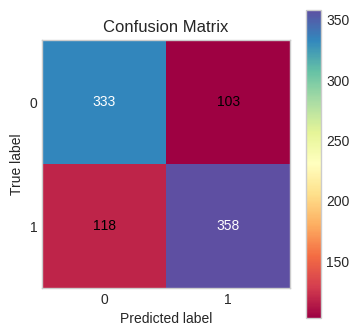

In [67]:
skplt.metrics.plot_confusion_matrix(cl_train_Y, cl_knn_pred, figsize=(4,4), cmap="Spectral")

Cross-validated accuracy score:

In [68]:
cvparam = KFold(5, random_state=13, shuffle=True)
scores_accuracy_knn_tr =  cross_val_score(cl_knn, cl_train_X_scaled, cl_train_Y, cv=cvparam, scoring='accuracy')

In [69]:
scores_accuracy_knn_tr.mean()*100

74.89461358313817

## Tree-Based Models


### Upload Data & Clean

In [70]:
df1 = pd.read_csv('/content/drive/My Drive/intropy/Session_10/Italy_Wave1.csv')
df2 = pd.read_csv('/content/drive/My Drive/intropy/Session_10/Italy_Wave3.csv', usecols=['idstd', 'COVb0'])
df2.rename(columns={'COVb0': 'openstatus'}, inplace=True)
df_italy = pd.merge(df1, df2, on='idstd', how='left')


df3 = pd.read_csv('/content/drive/My Drive/intropy/Session_10/Greece_Wave1.csv')
df4 = pd.read_csv('/content/drive/My Drive/intropy/Session_10/Greece_Wave3.csv', usecols=['idstd', 'COVb0'])
df4.rename(columns={'COVb0': 'openstatus'}, inplace=True)
df_greece = pd.merge(df1, df2, on='idstd', how='left')

# Combine Italy and Greece data
df = pd.concat([df_italy, df_greece], ignore_index=True)

In [71]:
#replace missing with NaN
df.replace(".", np.nan, inplace=True)

values_to_replace = ["Don't know (spontaneous)", "Does not apply (spontaneous)", "Don't know", "Does not apply"]
df.replace(values_to_replace, np.nan, inplace=True)

df = df.replace([-99, -9, -77, -7], np.nan)

#COVe4 -77
# Replace the string '-77' with NaN
df = df.replace('-77', np.nan)
df = df.replace('-7', np.nan)

In [72]:
# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().mean()

# Identify columns where the percentage of missing values is greater than 50%
columns_to_drop = missing_percentage[missing_percentage > 0.5].index

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop)

# List of columns to be dropped (not relevant variables or not included in data dictionary or survey documentation)
columns_to_drop2 = ["id", "a1", "COVb0", "mode", "a1a", 'a22', 'a23', 'a24', 'a25', 'a26', "COVa20y", "COVa20m", "COVa20d", "COVa20m_1", "COVg1", "COVg3", "COVg4", 'statuscode','eligibilitycode', 'strata', 'wmedian_ES', 'wmedian_COVID', 'wweak_COVID', 'idstd']

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop2)


In [73]:
# Replacing labels with numbers, ordinal
df.replace({'Increase': 1, 'Remain the same': 2, 'Decrease':3}, inplace=True)

# Convert continuous variables to float
continuous_vars = ['COVb3a', 'COVb3b', 'COVb3c', 'COVc5', 'COVc6', 'COVd1', 'COVd2', 'COVd8']
df[continuous_vars] = df[continuous_vars].astype(float)

In [74]:
import pandas as pd

# Create dummy variables
df['Open'] = df['openstatus'].apply(lambda x: 1 if x == "Open" else 0)

#df['PermClosed'] = df['openstatus'].apply(lambda x: 1 if x == "Permanently closed" else 0)

# Drop the original 'openstatus' column
df = df.drop('openstatus', axis=1)


In [75]:
# dropping subjects with majority missing data
#min_non_nan = int(df.shape[1] * 0.5)
#df = df.dropna(thresh=min_non_nan)

In [76]:
df.rename(columns={'Open': 'target'}, inplace=True)
#df.rename(columns={'NotOpen': 'target'}, inplace=True)

In [77]:
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import random

# List of ordinal and continuous variables
ordinal_vars = ['COVb2a', 'COVb4', 'COVc2a', 'COVc2c', 'COVc2b', 'COVd3a', 'COVd3b', 'COVe1a', 'COVe1b', 'COVe1c']
continuous_vars = ['COVb3a', 'COVb3b', 'COVb3c', 'COVc5', 'COVc6', 'COVd1', 'COVd2', 'COVd8']

# Variables to exclude from imputation
exclude_imputation = ['target']

# Create imputer for median
median_imputer = SimpleImputer(strategy='median')

def proportional_imputation(column):
    # Get the distribution of non-NaN values
    value_counts = column.value_counts(normalize=True)

    # Generate random values according to the distribution
    return column.apply(lambda x: np.random.choice(value_counts.index, p=value_counts.values) if pd.isnull(x) else x)

# Iterate over each column in the DataFrame
for column in df.columns:
    # Skip imputation for excluded variables
    if column in exclude_imputation:
        continue

    if column in ordinal_vars or column in continuous_vars:
        # Impute using median for ordinal and continuous variables
        df[[column]] = median_imputer.fit_transform(df[[column]])
    else:
        # Impute using proportional value for categorical variables
        df[column] = proportional_imputation(df[column])



In [78]:
cl_traindata = df

# List of specific columns you want to keep, with the 'COV' prefix added
columns_to_keep = ['COVd8', 'COVd1', 'target']

# Select these columns from your DataFrame
df = df[columns_to_keep]

### Tree Based Classification

In [79]:
# First, handle the target variable
targetdummy = pd.get_dummies(df['target'])
df['target2'] = targetdummy[1]
yvar = df['target2'].astype('float64')

# Now, create dummies for all other categorical variables
# Ensure you exclude the original and dummy target variables
Xvar = pd.get_dummies(df.drop(['target', 'target2'], axis=1))

# Converting Xvar to float64 is not necessary if it's already in a suitable numeric format
# Xvar = Xvar.astype('float64')



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [80]:
# Split the data into training and test portions:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(Xvar, yvar, test_size=0.40, random_state=7)
print(X2_train.shape, Y2_train.shape)
print(X2_test.shape, Y2_test.shape)

(912, 2) (912,)
(608, 2) (608,)


### Decision Tree Classifier Model


In [81]:
# Select the model approach for fitting: Decision Tree Classifier
DT_target = DecisionTreeClassifier(random_state=23)

In [82]:
# set the gridsearch parameters for decision tree
dtc_param_grid={'max_depth':[5, 7, 10], 'max_leaf_nodes':np.arange(2,10), 'max_features': [10, 15, 20]}

In [83]:
# define the gridsearch for decision tree classification:
dtc_grid_search = GridSearchCV(DT_target, dtc_param_grid, cv=5, scoring='accuracy')

In [84]:
# Fit the model on training data
dtc_grid_search.fit(X2_train, Y2_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=23),
             param_grid={'max_depth': [5, 7, 10], 'max_features': [10, 15, 20],
                         'max_leaf_nodes': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='accuracy')

In [85]:
dtc_grid_search.cv_results_['mean_test_score']

array([0.62612742, 0.72050081, 0.7281691 , 0.73147181, 0.7325647 ,
       0.7380532 , 0.73915811, 0.7380472 , 0.62612742, 0.72050081,
       0.7281691 , 0.73147181, 0.7325647 , 0.7380532 , 0.73915811,
       0.7380472 , 0.62612742, 0.72050081, 0.7281691 , 0.73147181,
       0.7325647 , 0.7380532 , 0.73915811, 0.7380472 , 0.62612742,
       0.72050081, 0.7281691 , 0.73147181, 0.7325647 , 0.7380532 ,
       0.73915811, 0.7380472 , 0.62612742, 0.72050081, 0.7281691 ,
       0.73147181, 0.7325647 , 0.7380532 , 0.73915811, 0.7380472 ,
       0.62612742, 0.72050081, 0.7281691 , 0.73147181, 0.7325647 ,
       0.7380532 , 0.73915811, 0.7380472 , 0.62612742, 0.72050081,
       0.7281691 , 0.73147181, 0.7325647 , 0.7380532 , 0.73915811,
       0.7380472 , 0.62612742, 0.72050081, 0.7281691 , 0.73147181,
       0.7325647 , 0.7380532 , 0.73915811, 0.7380472 , 0.62612742,
       0.72050081, 0.7281691 , 0.73147181, 0.7325647 , 0.7380532 ,
       0.73915811, 0.7380472 ])

In [86]:
dtc_grid_search.best_params_

{'max_depth': 5, 'max_features': 10, 'max_leaf_nodes': 8}

In [87]:
dtc_grid_search.best_estimator_

DecisionTreeClassifier(max_depth=5, max_features=10, max_leaf_nodes=8,
                       random_state=23)

We can visualize the Decision Tree as following:

In [88]:
#get the names of the independent variables for using them in the tree plot
df_features=df.drop(['target','target2'], axis=1).columns

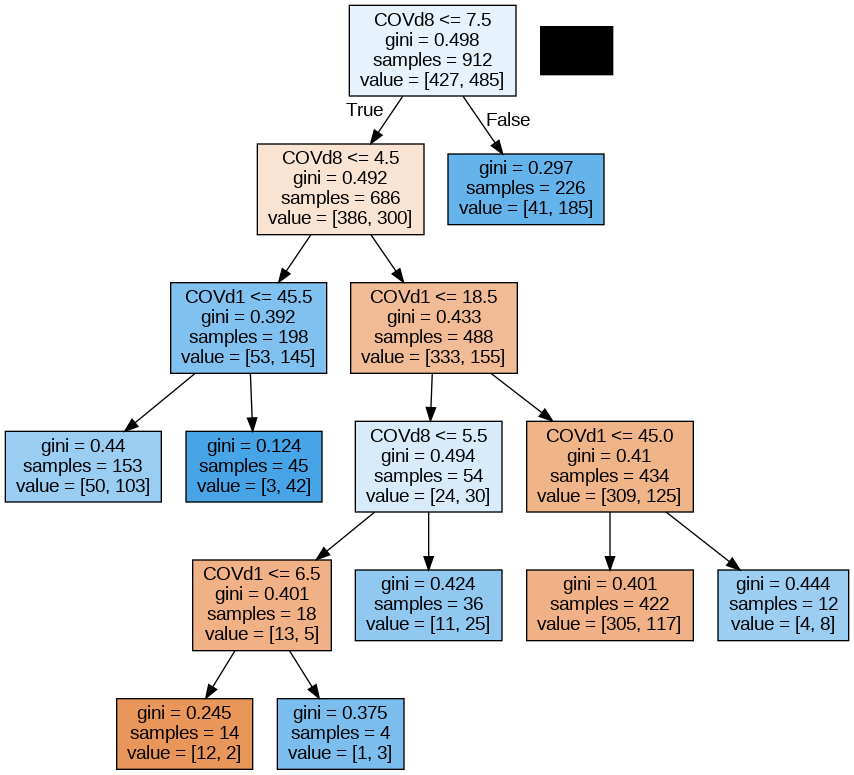

In [89]:
# Get the correct feature names from the DataFrame used for training
df_features = Xvar.columns

# Now, you can use df_features for the print_tree function
DTcgraph = print_tree(dtc_grid_search.best_estimator_, features=df_features)
Image(DTcgraph.create_png())


In [90]:
# Get the predictions of the best decision tree classifier
DT_prediction_ctc=dtc_grid_search.best_estimator_.predict(X2_test)

In [91]:
# Evaluate how good the decision tree classification is:
cm_DTC = confusion_matrix(Y2_test, DT_prediction_ctc)
print("Confusion Matrix:\n", cm_DTC)
print("\n")
print("Classification Report:\n",classification_report(Y2_test, DT_prediction_ctc))

Confusion Matrix:
 [[203  74]
 [ 81 250]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.73      0.72       277
         1.0       0.77      0.76      0.76       331

    accuracy                           0.75       608
   macro avg       0.74      0.74      0.74       608
weighted avg       0.75      0.75      0.75       608



Performs similar to model with all variables despite only two being needed.

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

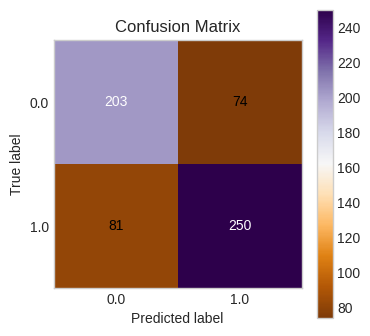

In [92]:
skplt.metrics.plot_confusion_matrix(Y2_test, DT_prediction_ctc, figsize=(4,4), cmap="PuOr")

Change colors using the [cmap parameter](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)

In [93]:
1-df.target2.mean()

0.4631578947368421

### Random Forest Classifier Model

In [94]:
# Select the model approach for fitting: RandomForest Classifier
DT_target_rfc = RandomForestClassifier(random_state=23)

In [95]:
# set the gridsearch parameters for the RandomForest Classifier
dtfc_param_grid={'n_estimators': [10, 15, 20], 'max_depth':[5, 10, 15], \
                 'max_leaf_nodes':np.arange(2,10), 'min_samples_split':[5, 10, 15]}

In [96]:
# define the gridsearch for decision tree classification:
dtrfc_grid_search = GridSearchCV(DT_target_rfc, dtfc_param_grid, cv=5, scoring='accuracy')

In [97]:
# Fit the model on training data
dtrfc_grid_search.fit(X2_train, Y2_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=23),
             param_grid={'max_depth': [5, 10, 15],
                         'max_leaf_nodes': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [10, 15, 20]},
             scoring='accuracy')

In [98]:
dtrfc_grid_search.cv_results_['mean_test_score']

array([0.67550591, 0.66891251, 0.67001141, 0.67550591, 0.66891251,
       0.67001141, 0.67550591, 0.66891251, 0.67001141, 0.70401129,
       0.72159371, 0.72159371, 0.70401129, 0.72159371, 0.72159371,
       0.70401129, 0.72159371, 0.72159371, 0.7325587 , 0.7314598 ,
       0.7314598 , 0.7325587 , 0.7314598 , 0.7314598 , 0.7325587 ,
       0.7314598 , 0.7314598 , 0.7336576 , 0.7358554 , 0.7314658 ,
       0.7336576 , 0.7336576 , 0.7314658 , 0.7336576 , 0.7325647 ,
       0.7314658 , 0.7369483 , 0.73694229, 0.73474449, 0.73255269,
       0.73474449, 0.73584339, 0.73255269, 0.73474449, 0.73584339,
       0.7314598 , 0.7369483 , 0.73035489, 0.7325587 , 0.73255269,
       0.73035489, 0.7314598 , 0.73365159, 0.73145379, 0.729268  ,
       0.7347505 , 0.73365159, 0.7303669 , 0.7347505 , 0.72925599,
       0.7281691 , 0.7347505 , 0.7325587 , 0.729268  , 0.7358494 ,
       0.7347565 , 0.7281691 , 0.7358494 , 0.7347565 , 0.7259713 ,
       0.73365159, 0.7336576 , 0.67550591, 0.66891251, 0.67001

In [99]:
dtrfc_grid_search.best_params_

{'max_depth': 10,
 'max_leaf_nodes': 9,
 'min_samples_split': 5,
 'n_estimators': 15}

In [100]:
dtrfc_grid_search.best_estimator_

RandomForestClassifier(max_depth=10, max_leaf_nodes=9, min_samples_split=5,
                       n_estimators=15, random_state=23)

In [101]:
# Get the predictions of the best Random Forest classifier
DTrfc_prediction_ctc=dtrfc_grid_search.best_estimator_.predict(X2_test)

In [102]:
# Evaluate how good the Random Forest classification is:
cm_DTC = confusion_matrix(Y2_test, DTrfc_prediction_ctc)
print("Confusion Matrix:\n", cm_DTC)
print("\n")
print("Classification Report:\n",classification_report(Y2_test, DTrfc_prediction_ctc, zero_division=1))

Confusion Matrix:
 [[204  73]
 [ 82 249]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.74      0.72       277
         1.0       0.77      0.75      0.76       331

    accuracy                           0.75       608
   macro avg       0.74      0.74      0.74       608
weighted avg       0.75      0.75      0.75       608



Performs similar to model with all variables despite only two being needed.

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

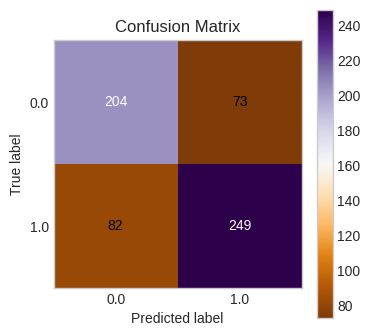

In [103]:
skplt.metrics.plot_confusion_matrix(Y2_test, DTrfc_prediction_ctc, figsize=(4,4), cmap="PuOr")

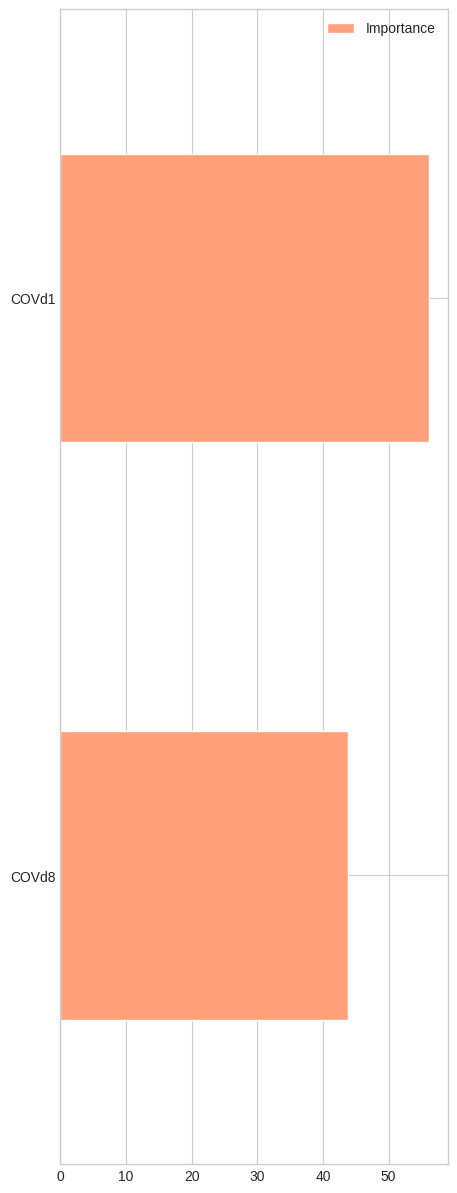

In [104]:
%matplotlib inline
Importance = pd.DataFrame({'Importance':dtrfc_grid_search.best_estimator_.feature_importances_*100}, \
                          index=df_features)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='lightsalmon', )
plt.gcf().set_size_inches(5, 15)

In [105]:
explainer2 = shap.TreeExplainer(dtrfc_grid_search.best_estimator_)
shap_values2=explainer2.shap_values(X2_test)
expected_value2 = explainer2.expected_value

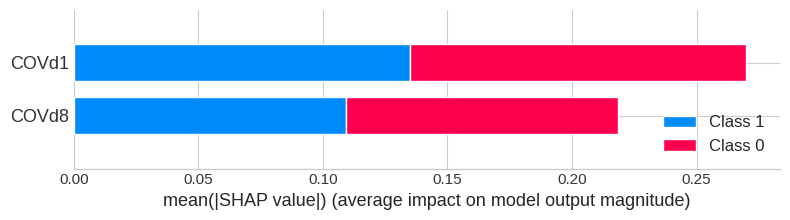

In [106]:
shap.summary_plot(shap_values2, X2_test, plot_type="bar", feature_names = df_features, max_display=100)